<a href="https://colab.research.google.com/github/Ekho852/Python/blob/main/Orange_Juice_wk1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Draft program for detecting Levels of orange in bottles
Below code simply takes in the image and then outputs the image when converted to greyscale

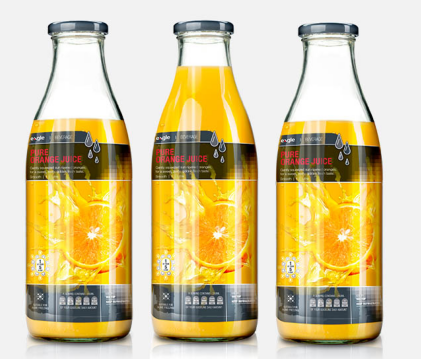

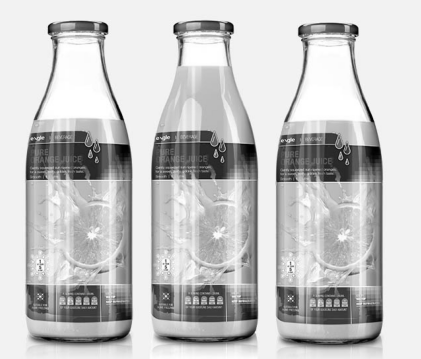

In [11]:
import cv2
from google.colab.patches import cv2_imshow

# Load an image
img = cv2.imread('/orange juice 2.png')

# Display the image
cv2_imshow(img)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Display the grayscale image
cv2_imshow(gray)


The below code demonstrates

The below code was a different way of approaching the problem without the explicit use of computer vision or image conversion by simply dividing up the image into 3 parts which completed covered each bottle and then simply counting the number of pixels.

Hypothetically, one could use this method to "guesstimate" the volume of the liquid inside the container assuming they have a known volume height standard for calibrating the machine.

For example in the below code, if we assume that bottle 1 and 3 are filled the correct volume of 1000ml which outputs approximately 16500 pixels, then the conversion to volume is a factor of 16500/1000 = 16.5 ie pixel count divided by 16.5 gives approximately volume of orange juice in bottle.

While this method is a different way of going about finding which bottle is filled the heighest it does not use the typical methods expected for this solution. It also has the shortcoming that it does not account for the volume that would be "behind" the black label

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

#Load and resize image
image = cv2.imread('/orange juice 2.png')
resized_image = cv2.resize(image, (450, 450))

# Slice the image into three pieces that include each bottle singularly
slice1 = resized_image[:, 0:150]
slice2 = resized_image[:, 150:290]
slice3 = resized_image[:, 291:450]

# Define the lower and upper bounds for orange color in HSV
lower_orange = np.array([10, 100, 20])
upper_orange = np.array([25, 255, 255])

# Function to count orange pixels in a slice
def count_orange_pixels(slice):
  hsv_slice = cv2.cvtColor(slice, cv2.COLOR_BGR2HSV)
  mask = cv2.inRange(hsv_slice, lower_orange, upper_orange)
  orange_pixels = cv2.countNonZero(mask)
  return orange_pixels

# Count orange pixels in each slice
orange_pixels_slice1 = count_orange_pixels(slice1)
orange_pixels_slice2 = count_orange_pixels(slice2)
orange_pixels_slice3 = count_orange_pixels(slice3)

# Calculate approximate volume assuming
pixels_to_volume = 16.5
approx_volume_slice1 = orange_pixels_slice1 / pixels_to_volume
approx_volume_slice2 = orange_pixels_slice2 / pixels_to_volume
approx_volume_slice3 = orange_pixels_slice3 / pixels_to_volume

# Print the results
print(f"Orange pixels in slice 1: {orange_pixels_slice1} Approx volume in slice 1: {approx_volume_slice1:.2f} ml")
print(f"Orange pixels in slice 2: {orange_pixels_slice2} Approx volume in slice 2: {approx_volume_slice2:.2f} ml")
print(f"Orange pixels in slice 3: {orange_pixels_slice3} Approx volume in slice 3: {approx_volume_slice3:.2f} ml")

#Print out possible error
if approx_volume_slice1 > 1050:
    print("Bottle A is overfilled")
if approx_volume_slice2 > 1050:
    print("Bottle B is overfilled")
if approx_volume_slice3 > 1050:
    print("Bottle C is overfilled")


# Display each slice (optional)
cv2_imshow(slice1)
cv2_imshow(slice2)
cv2_imshow(slice3)

The code below demonstrates improvements to the above program using various methods learned throughout the first weeks lesson using methods like the canny algorithm for edge detection

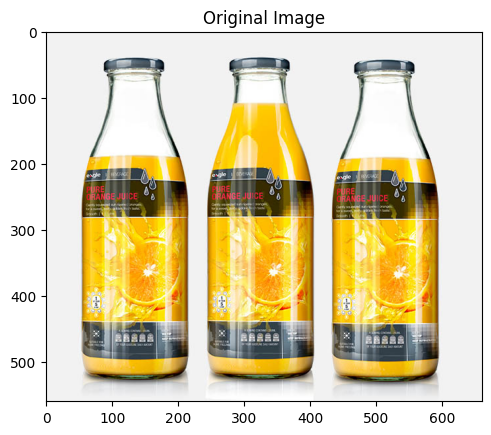

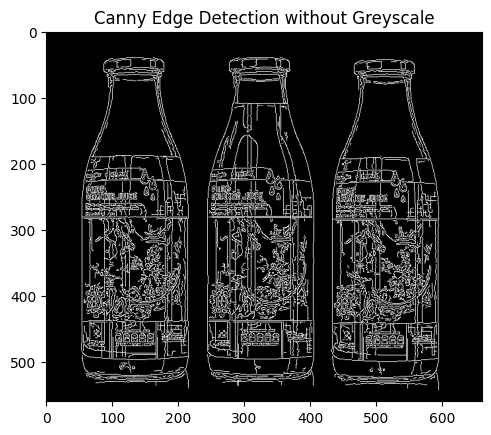

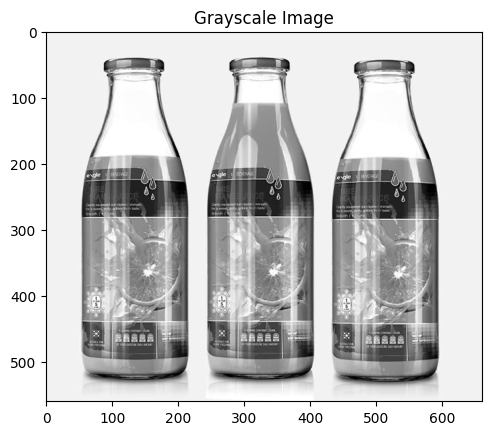

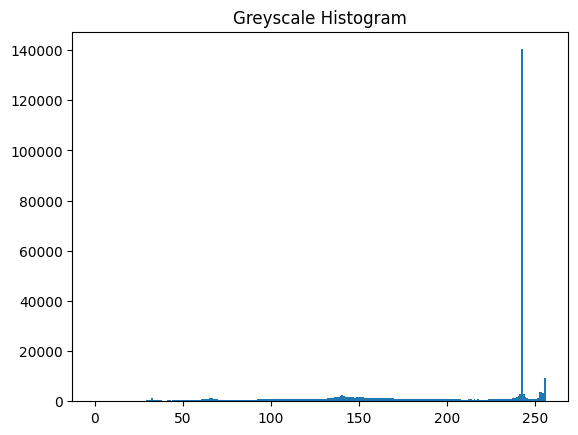

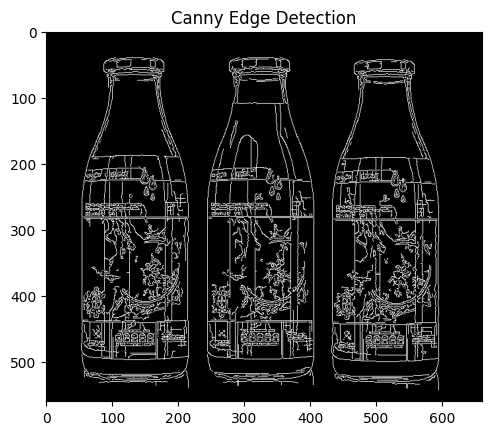

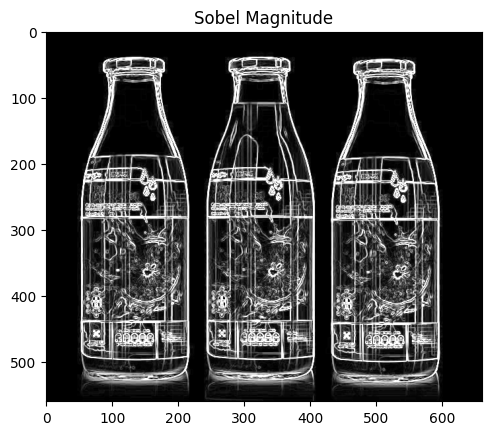

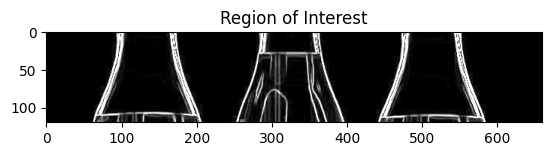

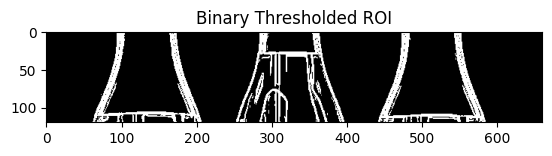

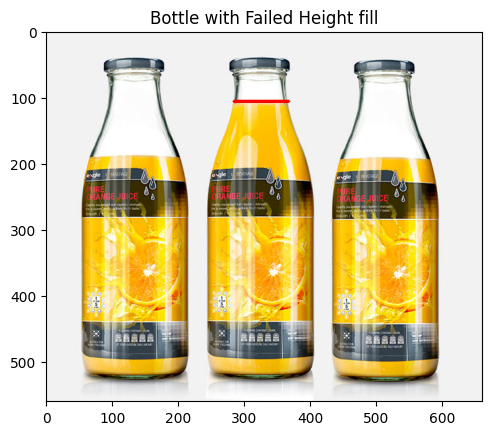

In [84]:
import numpy as np
from skimage import feature
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import urllib.request

def url_to_image(url):
	resp = urllib.request.urlopen(url)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB
	return temp_image

# read in test image
image_url = "https://cdn.eaglepi.com/uploads/2016/08/NEW_Fill_level_Rounded_Image_660pxh.jpg"

image = url_to_image(image_url)
# Display the original image
plt.imshow(image)
plt.title("Original Image")
plt.show()

# Apply Canny edge detection
coloredge = cv2.Canny(image, 80, 240)
plt.imshow(coloredge, cmap='gray')
plt.title("Canny Edge Detection without Greyscale")
plt.show()

# Convert to greyscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale Image")
plt.show()

# Show histogram
plt.hist(gray.ravel(),256,[0,256]);
plt.title('Greyscale Histogram')
plt.show()

# Apply Canny edge detection
edges = cv2.Canny(gray, 80, 240)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.show()

# Compare Sobel
def sobel_magnitude(gray):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)  # Sobel in X direction
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)  # Sobel in Y direction
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    return np.uint8(np.clip(sobel_mag, 0, 255))

# Get Sobel Magnitude
sobel_magnitude_image = sobel_magnitude(gray)

# Display Sobel Magnitude image
plt.imshow(sobel_magnitude_image, cmap='gray')
plt.title("Sobel Magnitude")
plt.show()

roi_start_y = 80
roi_end_y = 200

# Crop Sobel magnitude image to Region of Interest
sobel_roi = sobel_magnitude_image[roi_start_y:roi_end_y]

# Apply a binary threshold to highlight edges within the Region of interest
_, binary_thresholded = cv2.threshold(sobel_roi, 50, 255, cv2.THRESH_BINARY)

# Display ROI for sobel and Binary
plt.imshow(sobel_roi, cmap='gray')
plt.title("Region of Interest")
plt.show()

plt.imshow(binary_thresholded, cmap='gray')
plt.title("Binary Thresholded ROI")
plt.show()

# Find lines using Hough Transform
lines = cv2.HoughLinesP(binary_thresholded, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

# Initialize variables to store minimum height and corresponding line coordinates
lowest_line = None
min_height = float('inf')

# Analyze detected lines to find the lowest horizontal one
if lines is not None:
    for x1, y1, x2, y2 in (line[0] for line in lines):
        # Check if the line is horizontal (y coordinates should be close)
        if abs(y1 - y2) < 5:
            height = min(y1, y2)
            if height < min_height:
                min_height = height
                lowest_line = (x1, height + roi_start_y), (x2, height + roi_start_y)

# Draw the line
if lowest_line:
    cv2.line(image, lowest_line[0], lowest_line[1], (255, 0, 0), 3)

plt.imshow(image)
plt.title("Bottle with Failed Fill Height")
plt.show()


